# Bayesian Networks and Clustering

In this exercise we completed two tasks: 1) calculating probability by hand for a Bayesian network and 2) using clustering models to describe the spatial and temporal distribution of crime in Chicago.

In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
from collections import Counter, defaultdict

## Bayesian network by hand

The following is a learned Bayesian network structure explaining the relationships between variables in some shipping data:

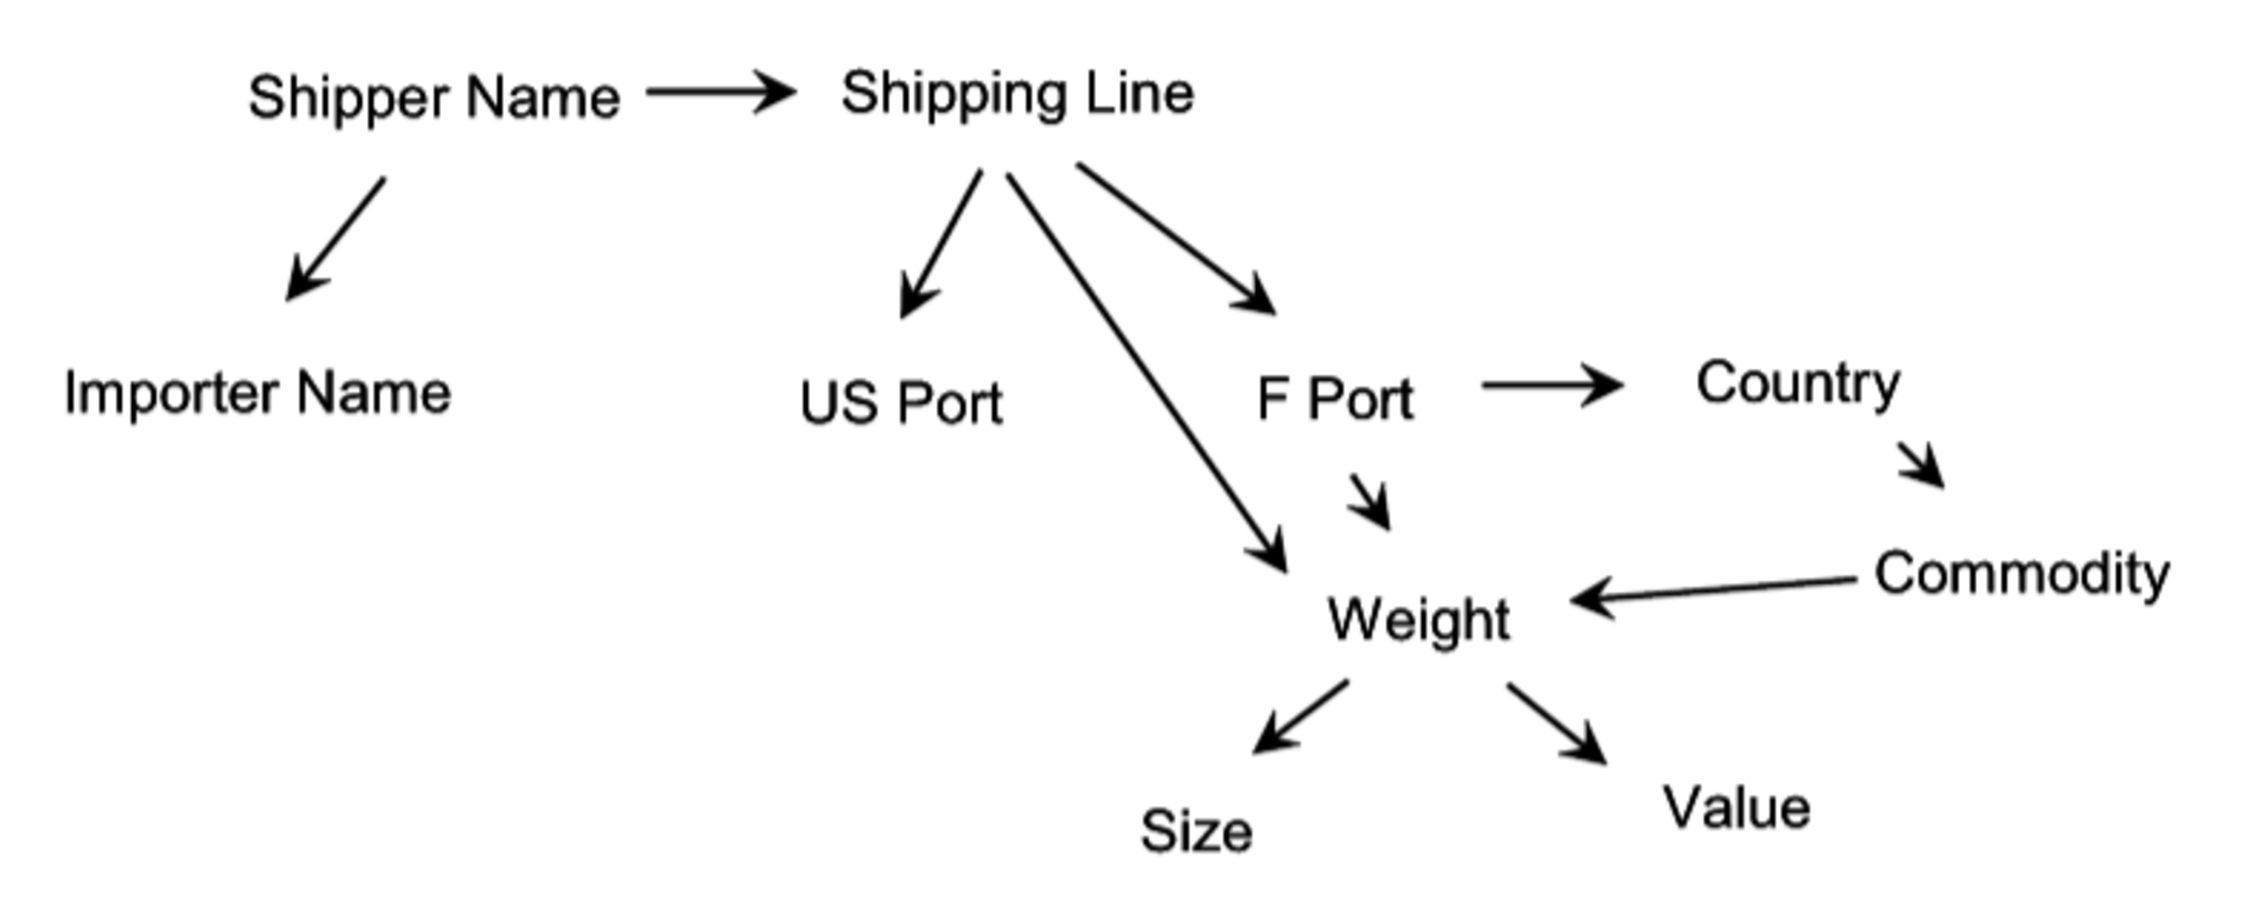

In [2]:
Image('data/shipping.png', width="700")

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Shipper Name, Value | F Port)? Dependent

CI (Shipper Name, Value | Shipping Line)? Independent

CI (Foreign Port, Commodity | Country)? Independent

CI (Foreign Port, Commodity | County, Weight)? Dependent

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (70%), ASCO (30%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (80%), Los Angeles (20%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (30%), Medium (50%), Heavy (20%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (30%), Heavy (60%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (15%), Medium (70%), Heavy (15%)

Which of the following packages is most anomalous?

a) A heavy package shipped from Vancouver to Seattle by ASCO

b) A heavy package shipped from Vancouver to Seattle by CSCO

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

Key:

* Shipping line ASCO: SA
* Shipping line CSCO: SC
* Foreign port Vancouver: FV
* Foreign port Yokohama: FY
* US port Seattle: US
* US port Los Angeles: ULA
* Weight light: WL
* Weight medium: WM
* Weight heavy: WH

a) Pr(SA) x Pr(FV | SA) x Pr(US | SA) x Pr(WH | SA, FV)

.3 x 1 x 1 x .15 = .045

b) Pr(SC) x Pr(FV | SC) x Pr(US | SC) x Pr(WH | SC, FV)

.7 x .6 x .8 x .2 = .067

c) Pr(SC) x Pr(FY | SC) x Pr(ULA | SC) x Pr(WH | SC, FY)

.7 x .4 x .2 x .6 = .034

Most anomalous: (c) A heavy package shipped from Yokohama to Los Angeles by CSCO

## Clustering: Spatial and Temporal Distributions of Chicago Crimes

Use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “data/cluster.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

Cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes. Then...

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.

b) Describe the three different hour-of-day trends represented by these three clusters.

c) Do you notice any consistent trends about which crime types are assigned to which cluster?

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file ("data/comms.csv"), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes?

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings.


In [3]:
chi_crimes=pd.read_csv("data/cluster.csv")
chi_crimes.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000


### Part a)

In [4]:
# Get time variables from original data for k-means clustering
time_vars_nums = []
time_vars_names = []
for col in chi_crimes.columns:
    if 'hour' in col:
        time_vars_nums.append(chi_crimes.columns.get_loc(col))
        time_vars_names.append(col)
print(time_vars_nums)
print("")
print(time_vars_names)

[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']


In [5]:
# Assign random cluster values to each crime type
random_clusters = np.random.randint(3,size=len(chi_crimes.index))
res=pd.concat([pd.Series(chi_crimes.crime_type),pd.Series(random_clusters,name='cluster')],axis=1)
res.head()

,crime_type,cluster
0,ARSON: BY FIRE,1
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,0
2,ASSAULT: AGGRAVATED: HANDGUN,0
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,2
4,ASSAULT: AGGRAVATED: OTHER FIREARM,0


In [6]:
# Create test data for clustering
test=chi_crimes.iloc[:,(time_vars_nums[0]):(time_vars_nums[-1])].values

In [7]:
# Use k-means in sklearn to cluster data into 3 k's using columns for hour of day proportions
km = KMeans(random_state=234,n_clusters=3)

km.fit(test)
res=km.predict(test)
res=pd.concat((pd.Series(chi_crimes.crime_type),pd.Series(res, name='cluster')),axis=1)

In [8]:
# Results of clustering
res.head()

,crime_type,cluster
0,ARSON: BY FIRE,1
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,1
2,ASSAULT: AGGRAVATED: HANDGUN,1
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,1
4,ASSAULT: AGGRAVATED: OTHER FIREARM,1


In [9]:
# Join the results back with the original data for plotting
joined = chi_crimes.merge(res, on='crime_type')
joined.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77,cluster
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833,1
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407,1
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152,1
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000,1
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000,1


In [10]:
# Get the time variable names for aggregation in the following cell
time_vars_names

['hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23']

In [11]:
# Aggregate the crime means for each cluster by hour for plotting
time_means = joined.groupby('cluster')[['hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23']].mean()
time_means

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.040281,0.013880,0.010799,0.009751,0.009108,0.007367,0.012765,0.024046,0.049803,0.089293,...,0.062441,0.066542,0.061529,0.052577,0.051869,0.044641,0.035504,0.027394,0.024409,0.020107
1,0.054579,0.041972,0.037463,0.031467,0.025630,0.019281,0.019833,0.024458,0.027246,0.033011,...,0.041317,0.047104,0.051500,0.054697,0.057559,0.055470,0.058328,0.054119,0.058607,0.052341
2,0.026195,0.015349,0.011751,0.005872,0.002640,0.001421,0.003865,0.007205,0.011146,0.021335,...,0.058630,0.044296,0.038586,0.041898,0.071305,0.108574,0.091606,0.081697,0.066990,0.040445


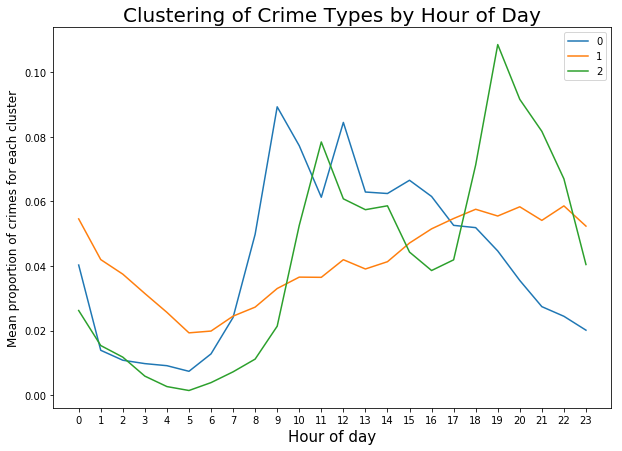

In [12]:
plt.figure(figsize=(10,7))
for i in range(3):
    plt.plot(range(24), time_means.iloc[i,:])
plt.xlabel('Hour of day', fontsize=15)
plt.ylabel('Mean proportion of crimes for each cluster', fontsize=12)
plt.title('Clustering of Crime Types by Hour of Day', fontsize=20)
plt.legend()
plt.xticks(np.arange(0, 24, step=1))
plt.show()

### Part b) - Description of trends

In the line graph above, we see crimes labeled as cluster 0 or 1 spike in the middle of the day while cluster 1 crimes gradually rise as the day progresses. All three crime clusters gradually decline in the middle of the night between midnight and 5 am.

Cluster 0 crimes spike in the middle of the day most likely because these crimes are more financial in nature. Lower-level financial crimes are often committed during business hours when individuals might attempt to cash a bad check, for example, or commit other similar crimes.

Cluster 2 crimes spike in the middle of the day but especially at night, which makes sense since narcotics use is the primary crime that falls within this category. More people are probably likely to use drugs at night, which would explain why more crimes within this cluster occur during the nighttime.

Cluster 1 crime types, on the other hand, have less of a dramatic spike and therefore are less subject to time than crimes labeled as cluster 0 or 2. These are crimes are more physically violent in nature and do not appear to depend on variables like normal business hours or recreational patterns that explain clusters 0 and 2.

### Part c)

In [13]:
# Get dictionaries with counts for each general crime category within each cluster
for i in range(3):
    crimes_dict = {}
    all_crimes = sorted(list(joined[joined['cluster']==i]['crime_type']))
    for crime in all_crimes:
        # Just get the general category
        crime = crime.split(':')[0]
        crimes_dict[crime] = crimes_dict.get(crime, 0) + 1
    print("Cluster " + str(i) + " crimes:")
    print(crimes_dict)
    print("")

Cluster 0 crimes:
{'DECEPTIVE PRACTICE': 9, 'BATTERY': 1, 'PUBLIC PEACE VIOLATION': 1, 'OTHER OFFENSE': 8, 'NARCOTICS': 1, 'SEX OFFENSE': 1, 'ASSAULT': 2, 'THEFT': 3, 'OFFENSE INVOLVING CHILDREN': 2, 'BURGLARY': 1, 'WEAPONS VIOLATION': 1}

Cluster 1 crimes:
{'HOMICIDE': 1, 'DECEPTIVE PRACTICE': 2, 'WEAPONS VIOLATION': 2, 'THEFT': 4, 'ARSON': 1, 'LIQUOR LAW VIOLATION': 1, 'BATTERY': 12, 'STALKING': 1, 'CRIMINAL TRESPASS': 4, 'NARCOTICS': 2, 'INTERFERENCE WITH PUBLIC OFFICER': 1, 'CRIMINAL DAMAGE': 5, 'ASSAULT': 5, 'CRIM SEXUAL ASSAULT': 2, 'OTHER OFFENSE': 5, 'ROBBERY': 9, 'OFFENSE INVOLVING CHILDREN': 2, 'BURGLARY': 3, 'MOTOR VEHICLE THEFT': 3, 'SEX OFFENSE': 2}

Cluster 2 crimes:
{'DECEPTIVE PRACTICE': 1, 'WEAPONS VIOLATION': 1, 'PUBLIC PEACE VIOLATION': 1, 'OTHER OFFENSE': 4, 'PROSTITUTION': 1, 'INTERFERENCE WITH PUBLIC OFFICER': 1, 'GAMBLING': 1, 'NARCOTICS': 12}



In [14]:
# Get more info on "DECEPTIVE PRACTICE"
joined[joined['crime_type'].str.contains('DEC')].crime_type

36     DECEPTIVE PRACTICE: ATTEMPT - FINANCIAL IDENTI...
37                       DECEPTIVE PRACTICE: BOGUS CHECK
38                 DECEPTIVE PRACTICE: COUNTERFEIT CHECK
39           DECEPTIVE PRACTICE: COUNTERFEITING DOCUMENT
40                 DECEPTIVE PRACTICE: CREDIT CARD FRAUD
41     DECEPTIVE PRACTICE: FINANCIAL IDENTITY THEFT $...
42     DECEPTIVE PRACTICE: FINANCIAL IDENTITY THEFT O...
43                           DECEPTIVE PRACTICE: FORGERY
44          DECEPTIVE PRACTICE: FRAUD OR CONFIDENCE GAME
45             DECEPTIVE PRACTICE: ILLEGAL USE CASH CARD
46           DECEPTIVE PRACTICE: THEFT OF LABOR/SERVICES
47        DECEPTIVE PRACTICE: THEFT OF LOST/MISLAID PROP
106                        SEX OFFENSE: PUBLIC INDECENCY
Name: crime_type, dtype: object

In [15]:
# Get more info on "DECEPTIVE PRACTICE"
joined[joined['crime_type'].str.contains('OTHER OFFENSE')].crime_type

74           OFFENSE INVOLVING CHILDREN: OTHER OFFENSE
75                 OTHER OFFENSE: ANIMAL ABUSE/NEGLECT
76             OTHER OFFENSE: FALSE/STOLEN/ALTERED TRP
77    OTHER OFFENSE: GUN OFFENDER: ANNUAL REGISTRATION
78       OTHER OFFENSE: GUN OFFENDER: DUTY TO REGISTER
79       OTHER OFFENSE: HARASSMENT BY ELECTRONIC MEANS
80              OTHER OFFENSE: HARASSMENT BY TELEPHONE
81                    OTHER OFFENSE: LICENSE VIOLATION
82           OTHER OFFENSE: OTHER CRIME AGAINST PERSON
83       OTHER OFFENSE: OTHER CRIME INVOLVING PROPERTY
84                OTHER OFFENSE: OTHER VEHICLE OFFENSE
85              OTHER OFFENSE: OTHER WEAPONS VIOLATION
86                     OTHER OFFENSE: PAROLE VIOLATION
87       OTHER OFFENSE: SEX OFFENDER: FAIL REG NEW ADD
88       OTHER OFFENSE: SEX OFFENDER: FAIL TO REGISTER
89                     OTHER OFFENSE: TELEPHONE THREAT
90            OTHER OFFENSE: VEHICLE TITLE/REG OFFENSE
91          OTHER OFFENSE: VIOLATE ORDER OF PROTECTION
Name: crim

### Crime types by cluster

Cluster 2 crimes have a noticeable trend, namely that they all seem to revolve around crimes of vice and, in particular, narcotics. We can tell this by the number of separate crime types (12) that all fall under the general domain of narcotics. 

Cluster 0 crimes, on the other hand, are more focused around financial fraud with 9 separate crime types in this category falling under "Deceptive Practice," which includes crimes such as counterfeit, identity theft, and other low-level theft.

Cluster 1 crimes, finally, are more physical and violent in nature. Battery is the most common general crime type within this cluster, with 12 separate offenses falling under this domain. Other major offenses within this cluster include robbery, assault, criminal damage, and other offenses.

### Part d)

In [16]:
# Get day of week variables from original data
day_vars_nums = []
day_vars_names = []
for col in chi_crimes.columns:
    if 'day' in col:
        day_vars_nums.append(chi_crimes.columns.get_loc(col))
        day_vars_names.append(col)
print(day_vars_names)
print("")
print(day_vars_nums)

['day_Sun', 'day_Mon', 'day_Tue', 'day_Wed', 'day_Thu', 'day_Fri', 'day_Sat']

[2, 3, 4, 5, 6, 7, 8]


In [17]:
# Aggregate the crime means for each cluster by day of week for plotting
day_means = joined.groupby('cluster')[['day_Sun', 'day_Mon', 'day_Tue', 'day_Wed', 'day_Thu', \
                                       'day_Fri', 'day_Sat']].mean()
day_means

,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat
cluster,,,,,,,
0,0.109048,0.150802,0.152768,0.153355,0.154315,0.158362,0.121350
1,0.147380,0.139490,0.138622,0.134765,0.136478,0.149898,0.153368
2,0.117608,0.142244,0.157875,0.148049,0.144648,0.155807,0.133768


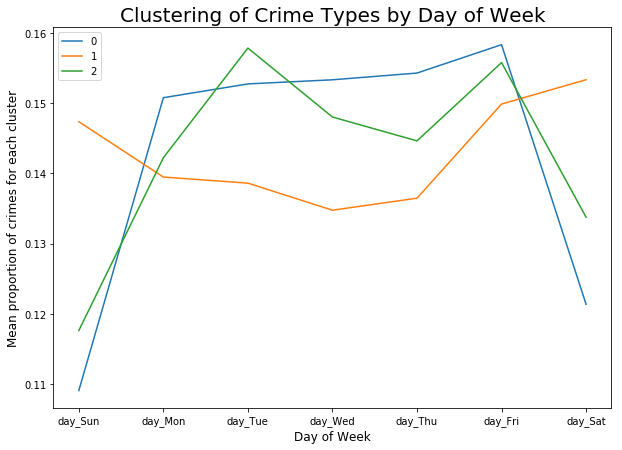

In [18]:
plt.figure(figsize=(10,7))
for i in range(3):
    plt.plot(day_means.columns.values, day_means.iloc[i,:])
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Mean proportion of crimes for each cluster', fontsize=12)
plt.title('Clustering of Crime Types by Day of Week', fontsize=20)
plt.legend()
plt.xticks(np.arange(0, 7, step=1))
plt.show()

## Observations:

It makes sense that cluster 0 crimes tend to occur during weekdays since these are financial in nature and therefore are somewhat dependent on normal business hours.

The drop in cluster 2 crimes during weekends is slightly less intuitive since I would have expected to see more violations related to drug use on weekends when people are engaged in more recreational activities, such as drug use.

Finally, the consistent occurrence of cluster 1 crimes, which are more physically violent in nature, makes some intuitive sense since these crimes do not depend on business hours or recreational patterns. Based on the pattern seen in the hourly analysis and the weekly analysis here, these crimes are apparently more likely to occur at any given time and are less easily predicted for a specific day or time.

### Part e)

In [19]:
# Get community variables from original data
comms_vars_names = []
for col in chi_crimes.columns:
    if 'comm' in col:
        comms_vars_names.append(col)
comms_vars_names

['community_area_1',
 'community_area_2',
 'community_area_3',
 'community_area_4',
 'community_area_5',
 'community_area_6',
 'community_area_7',
 'community_area_8',
 'community_area_9',
 'community_area_10',
 'community_area_11',
 'community_area_12',
 'community_area_13',
 'community_area_14',
 'community_area_15',
 'community_area_16',
 'community_area_17',
 'community_area_18',
 'community_area_19',
 'community_area_20',
 'community_area_21',
 'community_area_22',
 'community_area_23',
 'community_area_24',
 'community_area_25',
 'community_area_26',
 'community_area_27',
 'community_area_28',
 'community_area_29',
 'community_area_30',
 'community_area_31',
 'community_area_32',
 'community_area_33',
 'community_area_34',
 'community_area_35',
 'community_area_36',
 'community_area_37',
 'community_area_38',
 'community_area_39',
 'community_area_40',
 'community_area_41',
 'community_area_42',
 'community_area_43',
 'community_area_44',
 'community_area_45',
 'community_area_46

In [20]:
# Get the proportions for all the community areas
comms_props = joined.groupby(['cluster'])[['community_area_1',
 'community_area_2',
 'community_area_3',
 'community_area_4',
 'community_area_5',
 'community_area_6',
 'community_area_7',
 'community_area_8',
 'community_area_9',
 'community_area_10',
 'community_area_11',
 'community_area_12',
 'community_area_13',
 'community_area_14',
 'community_area_15',
 'community_area_16',
 'community_area_17',
 'community_area_18',
 'community_area_19',
 'community_area_20',
 'community_area_21',
 'community_area_22',
 'community_area_23',
 'community_area_24',
 'community_area_25',
 'community_area_26',
 'community_area_27',
 'community_area_28',
 'community_area_29',
 'community_area_30',
 'community_area_31',
 'community_area_32',
 'community_area_33',
 'community_area_34',
 'community_area_35',
 'community_area_36',
 'community_area_37',
 'community_area_38',
 'community_area_39',
 'community_area_40',
 'community_area_41',
 'community_area_42',
 'community_area_43',
 'community_area_44',
 'community_area_45',
 'community_area_46',
 'community_area_47',
 'community_area_48',
 'community_area_49',
 'community_area_50',
 'community_area_51',
 'community_area_52',
 'community_area_53',
 'community_area_54',
 'community_area_55',
 'community_area_56',
 'community_area_57',
 'community_area_58',
 'community_area_59',
 'community_area_60',
 'community_area_61',
 'community_area_62',
 'community_area_63',
 'community_area_64',
 'community_area_65',
 'community_area_66',
 'community_area_67',
 'community_area_68',
 'community_area_69',
 'community_area_70',
 'community_area_71',
 'community_area_72',
 'community_area_73',
 'community_area_74',
 'community_area_75',
 'community_area_76',
 'community_area_77']].sum().groupby(level=0, axis=1).apply(lambda x: x / x.sum())
comms_props

,community_area_1,community_area_2,community_area_3,community_area_4,community_area_5,community_area_6,community_area_7,community_area_8,community_area_9,community_area_10,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.268485,0.291143,0.312262,0.377153,0.400240,0.329621,0.400064,0.402811,0.526477,0.448718,...,0.169495,0.196840,0.291217,0.222906,0.418245,0.257146,0.497075,0.289392,0.271303,0.410236
1,0.619059,0.615285,0.593510,0.570820,0.549988,0.611019,0.569659,0.513648,0.398255,0.491194,...,0.557404,0.610372,0.652986,0.566699,0.536608,0.583634,0.449657,0.529906,0.707387,0.556586
2,0.112456,0.093572,0.094228,0.052027,0.049771,0.059360,0.030276,0.083541,0.075268,0.060089,...,0.273100,0.192788,0.055798,0.210394,0.045147,0.159220,0.053268,0.180702,0.021310,0.033178


In [21]:
# Community areas with highest proportions for each cluster
highest = list(comms_props.idxmax(axis=1))
highest_comm_nums = []
for comm in highest:
    highest_comm_nums.append(int(comm.split('_')[-1]))
print("Community areas with highest proportions for each cluster")
for i in range(3):
    print("Cluster " + str(i) + ":")
    print(highest_comm_nums[i])
    print("")

Community areas with highest proportions for each cluster
Cluster 0:
9

Cluster 1:
36

Cluster 2:
26



In [22]:
# Community areas with lowest proportions for each cluster
lowest = list(comms_props.idxmin(axis=1))
lowest_comm_nums = []
print("Community areas with lowest proportions for each cluster")
for comm in lowest:
    lowest_comm_nums.append(int(comm.split('_')[-1]))
for i in range(3):
    print("Cluster " + str(i) + ":")
    print(lowest_comm_nums[i])
    print("")

Community areas with lowest proportions for each cluster
Cluster 0:
26

Cluster 1:
9

Cluster 2:
76



### Comparison with communities data

In [23]:
# Bring in the data with communities' socioeconomics and other stats
communities=pd.read_csv("data/comms.csv")
communities.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


In [24]:
# Communities with highest proportions of each of the three clusters
highest_only = communities.loc[communities['Community Area Number'].isin(highest_comm_nums)]
highest_only

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
8,9,Edison Park,1125542.283,1945199.392,1.1,3.3,6.5,7.4,35.3,40959,4.794521,283
25,26,West Garfield Park,1148754.852,1898785.758,9.4,41.7,25.8,24.5,43.6,10934,27.504936,5340
35,36,Oakland,1182513.802,1879411.798,1.3,39.7,28.7,18.4,40.4,19252,12.974790,643


In [25]:
# Communities with lowest proportions of each of the three clusters
lowest_only = communities.loc[communities['Community Area Number'].isin(lowest_comm_nums)]
lowest_only

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
8,9,Edison Park,1125542.283,1945199.392,1.1,3.3,6.5,7.4,35.3,40959,4.794521,283
25,26,West Garfield Park,1148754.852,1898785.758,9.4,41.7,25.8,24.5,43.6,10934,27.504936,5340
75,76,O`Hare,1106851.170,1934484.285,3.6,15.4,7.1,10.9,30.3,25828,8.237232,1395


In [26]:
"""
Use this variable to change the amount to search above and below the mean within each column of the
communities dataset.
"""
std_multiplier = 1.5

In [27]:
# Look for any columns with proportions that are more or less than two SDs from the mean of each row
for i in range(highest_only.shape[0]):
    print("Community Area " + str(highest_only.iloc[i, 0]) + ": ")
    print("")
    for j in range(4,highest_only.shape[1]):
        h_val = highest_only.iloc[i, j]
        c_mean = communities.iloc[:, j].mean()
        c_std = communities.iloc[:, j].std() 
        test_above = h_val > (c_mean + std_multiplier*c_std)
        test_below = h_val < (c_mean - std_multiplier*c_std)
        if test_above == True:
            print("{} SD above mean for all communities: ".format(str(std_multiplier)))
            print(highest_only.columns[j] + ": " + str(h_val) + ", " + str(c_mean + std_multiplier*c_std))
            print("")
        elif test_below == True:
            print("{} SD below mean for all communities: ".format(str(std_multiplier)))
            print(highest_only.columns[j] + ": " + str(h_val) + ", " + str(c_mean - std_multiplier*c_std))
            print("")
        else:
            continue
    print("")

Community Area 9: 

1.5 SD below mean for all communities: 
PERCENT HOUSEHOLDS BELOW POVERTY: 3.3, 4.471298978567248


Community Area 26: 

1.5 SD above mean for all communities: 
PERCENT HOUSEHOLDS BELOW POVERTY: 41.7, 39.061168553900295

1.5 SD above mean for all communities: 
PERCENT OF HOUSING UNITS VACANT: 27.50493583, 21.199593833089466


Community Area 36: 

1.5 SD above mean for all communities: 
PERCENT HOUSEHOLDS BELOW POVERTY: 39.7, 39.061168553900295

1.5 SD above mean for all communities: 
PERCENT AGED 16+ UNEMPLOYED: 28.7, 26.687845034030207




In [28]:
# Look for any columns with proportions that are more or less than two SDs from the mean of each row
print("Characteristics of neighborhoods with lowest crime proportions for each cluster:")
print("")
for i in range(lowest_only.shape[0]):
    print("Community Area " + str(lowest_only.iloc[i, 0]) + ": ")
    print("")
    for j in range(4,lowest_only.shape[1]):
        l_val = lowest_only.iloc[i, j]
        c_mean = communities.iloc[:, j].mean()
        c_std = communities.iloc[:, j].std() 
        test_above = l_val > (c_mean + std_multiplier*c_std)
        test_below = l_val < (c_mean - std_multiplier*c_std)
        if test_above == True:
            print("{} SD above mean for all communities: ".format(str(std_multiplier)))
            print(lowest_only.columns[j] + ": " + str(l_val) + ", " + str(c_mean + std_multiplier*c_std))
        elif test_below == True:
            print("{} SD below mean for all communities: ".format(str(std_multiplier)))
            print(lowest_only.columns[j] + ": " + str(l_val) + ", " + str(c_mean - std_multiplier*c_std))
        else:
            continue  
    print("")

Characteristics of neighborhoods with lowest crime proportions for each cluster:

Community Area 9: 

1.5 SD below mean for all communities: 
PERCENT HOUSEHOLDS BELOW POVERTY: 3.3, 4.471298978567248

Community Area 26: 

1.5 SD above mean for all communities: 
PERCENT HOUSEHOLDS BELOW POVERTY: 41.7, 39.061168553900295
1.5 SD above mean for all communities: 
PERCENT OF HOUSING UNITS VACANT: 27.50493583, 21.199593833089466

Community Area 76: 




### Observations:

Community area 9 has the highest proportion of financial crimes (cluster 0) and the lowest proportion of physically violent crime (cluster 1). The high rate of financial crime makes some intuitive sense because this neighborhood has a relatively low poverty rate (more than 1.5 standard deviations below the mean for all communities) and therefore may be a target due to its affluence.

Community area 26, on the other hand, has the highest proportion of crimes involving narcotics (cluster 2) and the lowest proportion of financial crime (cluster 0) crimes. This neighborhood is more than 1.5 standard deviations above the mean for households below poverty and for the percentage of vacant units. Because this neighborhood is apparently relatively low-income, it makes some sense that it is not targeted for financial crimes.

Community area 36 had the highest proportion of physically violent crimes (cluster 1) and is also a relatively high-poverty area (more than 1.5 standard deviations above the mean for households in poverty and unemployed people aged 16+). It appears that in this case poverty is correlated with the occurrence of violent crime.

Finally, community area 76, which scores the lowest on crimes involving narcotics, is within 1.5 standard deviations of all categories within the communities dataset. In this case, the neighborhood does not appear to have any particularly notable socioeconomic characteristics.

### Part f)

In [29]:
joined_corr = joined.Category.str.get_dummies().corrwith(joined.cluster)
joined_corr

P1P   -0.115178
P1V    0.051383
P2     0.037519
dtype: float64

### Correlation

While there is some correlation between the clusters and the FBI's P1P crime category (property crime), there is little correlation between the other two cluster FBI categories and the clusters.

### Part g)


In [30]:
# Create new test data set using the days of the week rather than hours of the day
clustering_test = chi_crimes.iloc[:,(day_vars_nums[0]):(day_vars_nums[-1])].values

### K means with silhouette scores

In [31]:
range_n_clusters = range(2,10)

for n_clusters in range_n_clusters:
    new_km = KMeans(random_state=234,n_clusters=n_clusters)
    new_km.fit(clustering_test)
    new_km_res=new_km.predict(clustering_test)
    silhouette_avg = round(silhouette_score(clustering_test, new_km_res), 4)
    counter = Counter(new_km.labels_)
    print("n_clusters = {}:,".format(n_clusters))
    print("Silhouette score: {}".format(silhouette_avg) + "; Number of points per cluster: {}".format\
          (counter))
    print("")

n_clusters = 2:,
Silhouette score: 0.2247; Number of points per cluster: Counter({0: 64, 1: 55})

n_clusters = 3:,
Silhouette score: 0.223; Number of points per cluster: Counter({0: 61, 1: 43, 2: 15})

n_clusters = 4:,
Silhouette score: 0.2267; Number of points per cluster: Counter({2: 63, 1: 34, 0: 20, 3: 2})

n_clusters = 5:,
Silhouette score: 0.2426; Number of points per cluster: Counter({2: 62, 1: 37, 0: 13, 4: 5, 3: 2})

n_clusters = 6:,
Silhouette score: 0.1834; Number of points per cluster: Counter({2: 45, 1: 39, 0: 16, 3: 9, 5: 8, 4: 2})

n_clusters = 7:,
Silhouette score: 0.2001; Number of points per cluster: Counter({2: 48, 4: 40, 1: 12, 6: 8, 0: 6, 3: 3, 5: 2})

n_clusters = 8:,
Silhouette score: 0.1703; Number of points per cluster: Counter({1: 32, 6: 29, 7: 26, 3: 13, 2: 12, 0: 3, 4: 2, 5: 2})

n_clusters = 9:,
Silhouette score: 0.1844; Number of points per cluster: Counter({2: 34, 4: 31, 0: 20, 6: 15, 1: 10, 5: 4, 3: 2, 7: 2, 8: 1})



#### Optimal k-means

Given the results of the silhouette score averages above, the optimal number of centers for the k-means clustering for this data set is 5.

### Gaussian mixture model

In [32]:
range_n_components = range(2,10)

for n_components in range_n_clusters:
    gmm = GaussianMixture(n_components=n_components,random_state=100)
    gmm.fit(clustering_test)
    gmm_res=gmm.predict(clustering_test)
    silhouette_avg = round(silhouette_score(clustering_test, gmm_res), 4)
    counter = Counter(gmm_res)
    print("n_clusters = {}:,".format(n_components))
    print("Silhouette score: {}".format(silhouette_avg) + "; Number of points per cluster: {}".format\
          (counter))
    print("")

n_clusters = 2:,
Silhouette score: 0.2778; Number of points per cluster: Counter({1: 91, 0: 28})

n_clusters = 3:,
Silhouette score: 0.3126; Number of points per cluster: Counter({1: 89, 0: 15, 2: 15})

n_clusters = 4:,
Silhouette score: 0.1516; Number of points per cluster: Counter({0: 81, 1: 21, 2: 14, 3: 3})

n_clusters = 5:,
Silhouette score: 0.1485; Number of points per cluster: Counter({0: 77, 1: 24, 2: 13, 3: 3, 4: 2})

n_clusters = 6:,
Silhouette score: 0.1108; Number of points per cluster: Counter({0: 61, 1: 27, 2: 13, 5: 13, 3: 3, 4: 2})

n_clusters = 7:,
Silhouette score: 0.1349; Number of points per cluster: Counter({6: 38, 0: 27, 5: 17, 1: 16, 2: 16, 3: 3, 4: 2})

n_clusters = 8:,
Silhouette score: 0.0991; Number of points per cluster: Counter({3: 32, 6: 28, 0: 17, 5: 17, 2: 12, 1: 9, 4: 2, 7: 2})

n_clusters = 9:,
Silhouette score: 0.0938; Number of points per cluster: Counter({3: 45, 6: 26, 5: 14, 0: 9, 1: 9, 2: 7, 8: 5, 4: 2, 7: 2})



#### Optimal GMM

Given the results of the silhouette score averages above, the optimal number of centers for this model is 3.

### Bottom-up hierarchical clustering - single link

In [33]:
range_n_clusters = range(2,10)

Zs = linkage(clustering_test, 'single')

for n_clusters in range_n_clusters:
    cluster_labels=fcluster(Zs, n_clusters, criterion='maxclust')    
    silhouette_avg = silhouette_score(clustering_test, cluster_labels)
    counter = Counter(cluster_labels)
    print("n_clusters = {}:,".format(n_clusters))
    print("Silhouette score: {}".format(silhouette_avg) + "; Number of points per cluster: {}".format\
          (counter))
    print("")

n_clusters = 2:,
Silhouette score: 0.572063375998; Number of points per cluster: Counter({2: 117, 1: 2})

n_clusters = 3:,
Silhouette score: 0.455058957705; Number of points per cluster: Counter({3: 115, 1: 2, 2: 2})

n_clusters = 4:,
Silhouette score: 0.444920372458; Number of points per cluster: Counter({4: 115, 3: 2, 1: 1, 2: 1})

n_clusters = 5:,
Silhouette score: 0.389164146374; Number of points per cluster: Counter({4: 114, 3: 2, 1: 1, 2: 1, 5: 1})

n_clusters = 6:,
Silhouette score: 0.359605280828; Number of points per cluster: Counter({4: 113, 3: 2, 1: 1, 2: 1, 5: 1, 6: 1})

n_clusters = 7:,
Silhouette score: 0.371290426526; Number of points per cluster: Counter({4: 111, 3: 2, 5: 2, 1: 1, 2: 1, 6: 1, 7: 1})

n_clusters = 8:,
Silhouette score: 0.359118262774; Number of points per cluster: Counter({5: 111, 6: 2, 1: 1, 2: 1, 3: 1, 4: 1, 7: 1, 8: 1})

n_clusters = 9:,
Silhouette score: 0.33603208043; Number of points per cluster: Counter({5: 111, 1: 1, 2: 1, 3: 1, 4: 1, 6: 1, 7: 1,

#### Optimal single link

Given the results of the silhouette score averages above, the optimal number of centers for this model is 2.

### Bottom-up hierarchical clustering - complete link

In [34]:
range_n_clusters = range(2,10)

Zc = linkage(clustering_test, 'complete')

for n_clusters in range_n_clusters:
    cluster_labels=fcluster(Zc, n_clusters, criterion='maxclust')    
    silhouette_avg = silhouette_score(clustering_test, cluster_labels)
    counter = Counter(cluster_labels)
    print("n_clusters = {}:,".format(n_clusters))
    print("Silhouette score: {}".format(silhouette_avg) + "; Number of points per cluster: {}".format\
          (counter))
    print("")

n_clusters = 2:,
Silhouette score: 0.15186233708; Number of points per cluster: Counter({2: 105, 1: 14})

n_clusters = 3:,
Silhouette score: 0.187397922993; Number of points per cluster: Counter({3: 88, 2: 17, 1: 14})

n_clusters = 4:,
Silhouette score: 0.223642054092; Number of points per cluster: Counter({4: 84, 2: 17, 1: 14, 3: 4})

n_clusters = 5:,
Silhouette score: 0.234120174562; Number of points per cluster: Counter({5: 76, 2: 17, 1: 14, 4: 8, 3: 4})

n_clusters = 6:,
Silhouette score: 0.174582026564; Number of points per cluster: Counter({6: 76, 3: 17, 2: 12, 5: 8, 4: 4, 1: 2})

n_clusters = 7:,
Silhouette score: 0.171048600212; Number of points per cluster: Counter({7: 76, 3: 16, 2: 12, 6: 8, 5: 4, 1: 2, 4: 1})

n_clusters = 8:,
Silhouette score: 0.17957559402; Number of points per cluster: Counter({8: 76, 3: 16, 2: 12, 7: 8, 1: 2, 5: 2, 6: 2, 4: 1})

n_clusters = 9:,
Silhouette score: 0.14484931184; Number of points per cluster: Counter({9: 69, 3: 16, 2: 12, 7: 8, 8: 7, 1: 2,

#### Optimal complete link

Given the results of the silhouette score averages above, the optimal number of centers for this model is 5.

### Clustering comparison

Across the four separate clustering methods, we can see that the best results are obtained with relatively lower numbers of cluster centers (5, 3, 2, and 5, respectively). In this case, we can see that the silhouette scoring methodology supports avoid overfitting data even across separate clustering algorithms, from k-means to hierarchical models.